In [0]:
import pickle
import os
import numpy as np
import cv2
# from skimage import morphology, color, io, exposure
os.chdir('/content/drive/My Drive/Colab Notebooks/Chest X-Ray Images for Classification/')

#Load data

In [0]:
file_names = pickle.load(open('file_names','rb'))
def load_data(shape):
  X,Y = [],[]
  for file_name in file_names:
    path_img = '/content/drive/My Drive/Colab Notebooks/Chest X-Ray Images for Classification/dataset/' + file_name + '.png'
    path_mask = '/content/drive/My Drive/Colab Notebooks/Chest X-Ray Images for Classification/dataset/' + file_name + 'msk.png'
    img = cv2.imread(path_img,0)
    img = cv2.resize(img,(shape,shape)).reshape((shape,shape,1))
    X.append(img/255)
    msk = cv2.imread(path_mask,0)
    msk = cv2.resize(msk,(shape,shape)).reshape((shape,shape,1))
    Y.append(msk/255)
  return np.array(X),np.array(Y)

In [0]:
X,Y = load_data(256)

# Model

In [6]:
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D

def model(input_shape):
    size = 3
    data = Input(shape=(input_shape,input_shape,1))
    conv1 = Convolution2D(filters=32, kernel_size = size, padding='same', activation='relu')(data)
    conv1 = Convolution2D(filters=32, kernel_size = size, padding='same', activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(filters=64, kernel_size= size, padding='same', activation='relu')(pool1)
    conv2 = Convolution2D(filters=64, kernel_size= size, padding='same', activation='relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(filters=64, kernel_size= size, padding='same', activation='relu')(pool2)
    conv3 = Convolution2D(filters=64, kernel_size= size, padding='same', activation='relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(filters=128, kernel_size= size, padding='same', activation='relu')(pool3)
    conv4 = Convolution2D(filters=128, kernel_size= size, padding='same', activation='relu')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(filters=256, kernel_size= size, padding='same', activation='relu')(pool4)
    conv5 = Convolution2D(filters=256, kernel_size= size, padding='same', activation='relu')(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)


    conv6 = Convolution2D(filters=512, kernel_size= size, padding='same', activation='relu')(pool5)
    conv6 = Convolution2D(filters=512, kernel_size= size, padding='same', activation='relu')(conv6)


    up1 = UpSampling2D(size=(2, 2))(conv6)
    conv7 = Convolution2D(filters=256, kernel_size=size, padding='same', activation='relu')(up1)
    conv7 = Convolution2D(filters=256, kernel_size=size, padding='same', activation='relu')(conv7)
    concat1 = concatenate([conv5, conv7], axis = -1)
    conv7 = Convolution2D(filters=256, kernel_size=size, padding='same', activation='relu')(concat1)

    up2 = UpSampling2D(size=(2, 2))(conv7)
    conv8 = Convolution2D(filters=256, kernel_size=size, padding='same', activation='relu')(up2)
    conv8 = Convolution2D(filters=256, kernel_size=size, padding='same', activation='relu')(conv8)
    concat2 = concatenate([conv4, conv8], axis=-1)
    conv8 = Convolution2D(filters=256, kernel_size=size, padding='same', activation='relu')(concat2)

    up3 = UpSampling2D(size=(2, 2))(conv8)
    conv9 = Convolution2D(filters=128, kernel_size=size, padding='same', activation='relu')(up3)
    conv9 = Convolution2D(filters=128, kernel_size=size, padding='same', activation='relu')(conv9)
    concat3 = concatenate([conv3, conv9], axis=-1)
    conv9 = Convolution2D(filters=128, kernel_size=size, padding='same', activation='relu')(concat3)

    up4 = UpSampling2D(size=(2, 2))(conv9)
    conv10 = Convolution2D(filters=64, kernel_size=size, padding='same', activation='relu')(up4)
    conv10 = Convolution2D(filters=64, kernel_size=size, padding='same', activation='relu')(conv10)
    concat4 = concatenate([conv2, conv10], axis=-1)
    conv10 = Convolution2D(filters=64, kernel_size=size, padding='same', activation='relu')(concat4)

    up5 = UpSampling2D(size=(2, 2))(conv10)
    conv11 = Convolution2D(filters=64, kernel_size=size, padding='same', activation='relu')(up5)
    conv11 = Convolution2D(filters=64, kernel_size=size, padding='same', activation='relu')(conv11)
    concat5 = concatenate([conv1, conv11], axis=-1)
    conv11 = Convolution2D(filters=64, kernel_size=size, padding='same', activation='relu')(concat5)

    conv11 = Convolution2D(filters=1, kernel_size=size, padding='same', activation='sigmoid')(conv11)

    output = conv11
    model = Model(data, output)
    return model


Model = model(256)
print(Model.summary())

Using TensorFlow backend.







Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
_______________________________________________________________________________________

In [7]:
Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
save_model_to = '/content/drive/My Drive/Colab Notebooks/Chest X-Ray Images for Classification/model.hdf5'

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.10, shuffle=False)



callback = ModelCheckpoint(save_model_to, period=20)

train_data = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               zoom_range=0.2,
                               fill_mode='nearest',
                               cval=0)

test_data = ImageDataGenerator()

# Train Model

In [9]:
batch_size = 16
history = Model.fit_generator(train_data.flow(X_train, Y_train, batch_size),
                   epochs=100,
                   callbacks=[callback],
                   validation_data=test_data.flow(X_val, Y_val))




Epoch 1/100





14/14 [==============================] - 24s 2s/step - loss: 0.6553 - acc: 0.6630 - val_loss: 0.5414 - val_acc: 0.7108
Epoch 2/100
14/14 [==============================] - 3s 248ms/step - loss: 0.5759 - acc: 0.6905 - val_loss: 0.4705 - val_acc: 0.7108
Epoch 3/100
14/14 [==============================] - 4s 250ms/step - loss: 0.4937 - acc: 0.7379 - val_loss: 0.4015 - val_acc: 0.7349
Epoch 4/100
14/14 [==============================] - 3s 249ms/step - loss: 0.4200 - acc: 0.7939 - val_loss: 0.3677 - val_acc: 0.8906
Epoch 5/100
14/14 [==============================] - 3s 249ms/step - loss: 0.3721 - acc: 0.8265 - val_loss: 0.2689 - val_acc: 0.9071
Epoch 6/100
14/14 [==============================] - 3s 249ms/step - loss: 0.3125 - acc: 0.8557 - val_loss: 0.2358 - val_acc: 0.9067
Epoch 7/100
14/14 [==============================] - 3s 250ms/step - loss: 0.2779 - acc: 0.8777 - val_loss: 0.2555 - val_acc: 0.8867
Epoch 8/100
14/14 [==============================] - 3s 249ms/s

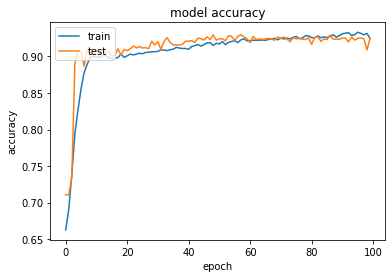

In [12]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

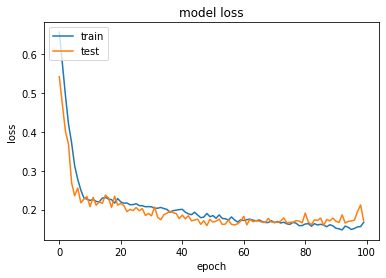

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Prediction

In [0]:
from keras.models import load_model
Model = load_model('/content/drive/My Drive/Colab Notebooks/Chest X-Ray Images for Classification/model.hdf5')

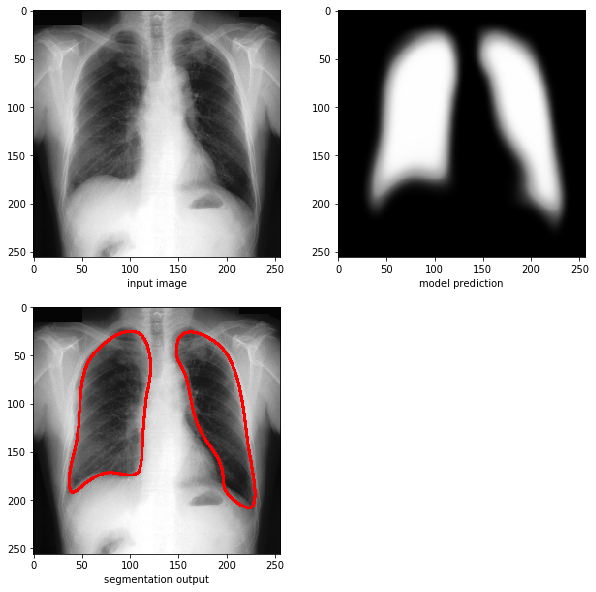

In [19]:
import matplotlib.pyplot as plt

#### image path
img_path = '/content/drive/My Drive/Colab Notebooks/Chest X-Ray Images for Classification/dataset/JPCLN013.png'  

def plot_output(img_path):
  img = cv2.imread(img_path)
  img = cv2.resize(img,(256,256))
  img_ = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_ = img_.reshape((256,256,1))
  out = Model.predict(np.array([img_/255]))
  out = out[0].reshape(256,256)

  cv2.imwrite('out.png',out*255)

  plt.figure(figsize=(10,10))
  plt.subplot(221)
  plt.xlabel('input image')
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

  plt.subplot(222)
  plt.xlabel('model prediction')
  plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))

  plt.subplot(223)
  plt.xlabel('segmentation output')
  out = cv2.imread('out.png',0)
  ret, thresh = cv2.threshold(out, 127, 255, 0)
  contours,_ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(img, contours, -1, (0,0,255), 2)
  plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plot_output(img_path)